In [ ]:
import os
# !pip install unrar
# !unrar x '/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/800_dataset_with_semantic_segmentation.rar'

In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
w, h = 256,256
border = 5 

In [ ]:
ids = next(os.walk("/content/drive/MyDrive/dataset4/257/images/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  300


# **Data Reading and Train test split**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import glob
train = sorted(glob.glob("/content/drive/MyDrive/dataset4/257/images/*.png"))
train_mask = sorted(glob.glob("/content/drive/MyDrive/dataset4/257/labels/*.png"))

print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 300
Total Mask Image : 300


In [ ]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [ ]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255.0
  y[n] = mask/255.0

0it [00:00, ?it/s]

In [ ]:
# Save the files in Numpy array for reusability
np.save('/content/drive/MyDrive/satellite-Image-Semantic-Segmentation-Unet-Tensorflow-keras/XandY/X.npy', X)
np.save('/content/drive/MyDrive/satellite-Image-Semantic-Segmentation-Unet-Tensorflow-keras/XandY/y.npy', y)
# print(X.shape, y.shape)
X = np.load('/content/drive/MyDrive/satellite-Image-Semantic-Segmentation-Unet-Tensorflow-keras/XandY/X.npy')
y = np.load('/content/drive/MyDrive/satellite-Image-Semantic-Segmentation-Unet-Tensorflow-keras/XandY/y.npy')
print(X.shape, y.shape)

(300, 256, 256, 3) (300, 256, 256, 1)


In [ ]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(270, 256, 256, 3) (270, 256, 256, 1) (30, 256, 256, 3) (30, 256, 256, 1)


208

# **Visualization the image and It masks**

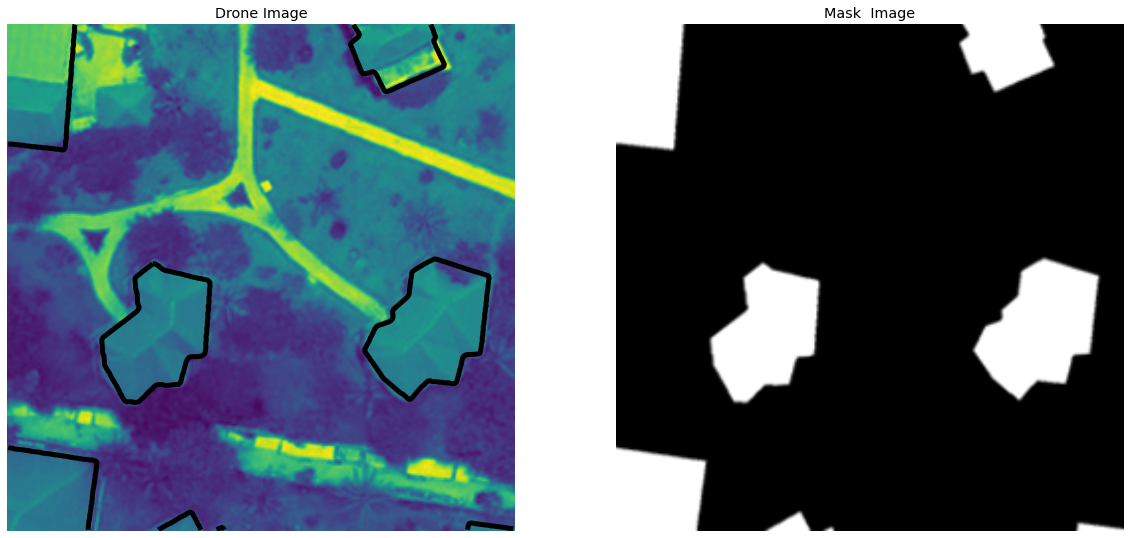

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Drone Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask  Image')
ax2.set_axis_off()

In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
# valset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def Unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
from tensorflow import keras

In [ ]:
from keras import backend as K
K.clear_session()

input_img = Input((h, w, 3), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5),
           tf.keras.metrics.MeanIoU(num_classes=2)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet-aug.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/50
45/45 [==============================] - 44s 167ms/step - loss: 0.4867 - accuracy: 0.7921 - auc: 0.7898 - sensitivity_at_specificity: 0.8599 - specificity_at_sensitivity: 0.8847 - mean_io_u: 0.4244 - val_loss: 0.5943 - val_accuracy: 0.6723 - val_auc: 0.5579 - val_sensitivity_at_specificity: 0.6278 - val_specificity_at_sensitivity: 0.5724 - val_mean_io_u: 0.4225

Epoch 00001: val_loss improved from inf to 0.59426, saving model to model-Unet-aug.h5
Epoch 2/50
45/45 [==============================] - 6s 132ms/step - loss: 0.3367 - accuracy: 0.8632 - auc: 0.8575 - sensitivity_at_specificity: 0.9121 - specificity_at_sensitivity: 0.9581 - mean_io_u: 0.4244 - val_loss: 0.4524 - val_accuracy: 0.8097 - val_auc: 0.7048 - val_sensitivity_at_specificity: 0.7295 - val_specificity_at_sensitivity: 0.7669 - val_mean_io_u: 0.4225

Epoch 00002: val_loss improved from 0.59426 to 0.45236, saving model to model-Unet-aug.h5
Epoch 3/50
45/45 [==============================] - 6s 134ms/step - loss:

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,mean_io_u,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,val_mean_io_u,lr
24,0.068806,0.952104,0.992761,0.996646,0.999854,0.425280,0.113893,0.934447,0.983459,0.991731,0.998222,0.422538,0.00010
25,0.067455,0.952359,0.993211,0.996897,0.999957,0.424945,0.114002,0.934997,0.983333,0.996990,0.997958,0.422538,0.00010
34,0.063466,0.953455,0.994145,0.997379,0.999948,0.425469,0.114263,0.935927,0.983056,0.997173,0.998033,0.422538,0.00001
32,0.062658,0.953895,0.994255,0.997183,0.999967,0.424911,0.114423,0.935847,0.982984,0.997086,0.998112,0.422538,0.00001
31,0.062574,0.954010,0.994132,0.997114,0.999960,0.425081,0.114545,0.935733,0.982963,0.997099,0.998091,0.422538,0.00001
30,0.064981,0.952968,0.993671,0.997240,0.999890,0.425629,0.114654,0.935691,0.982878,0.996987,0.997950,0.422538,0.00001
33,0.063972,0.953545,0.993670,0.996789,0.999946,0.425168,0.114670,0.935801,0.982844,0.997075,0.998021,0.422538,0.00001
29,0.064971,0.952992,0.993622,0.996852,0.999952,0.424811,0.114706,0.935613,0.982789,0.996729,0.998182,0.422538,0.00010
26,0.066515,0.952647,0.993341,0.996926,0.999947,0.424694,0.115351,0.934889,0.982822,0.989995,0.997856,0.422538,0.00010
27,0.067128,0.952488,0.993176,0.996771,0.999941,0.424826,0.115648,0.935372,0.982153,0.988305,0.997963,0.422538,0.00010


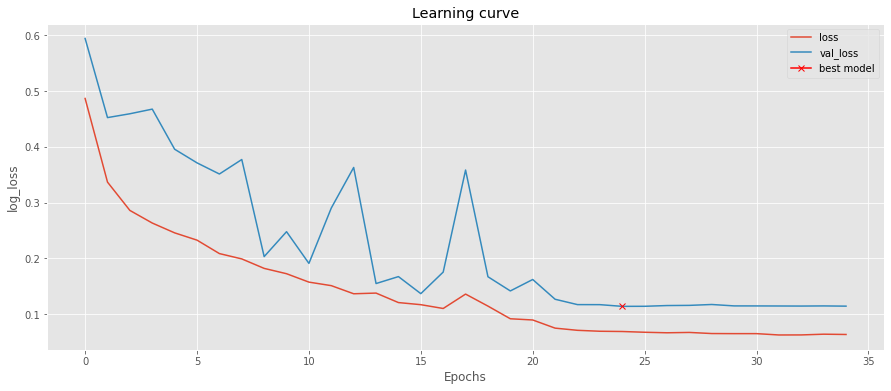

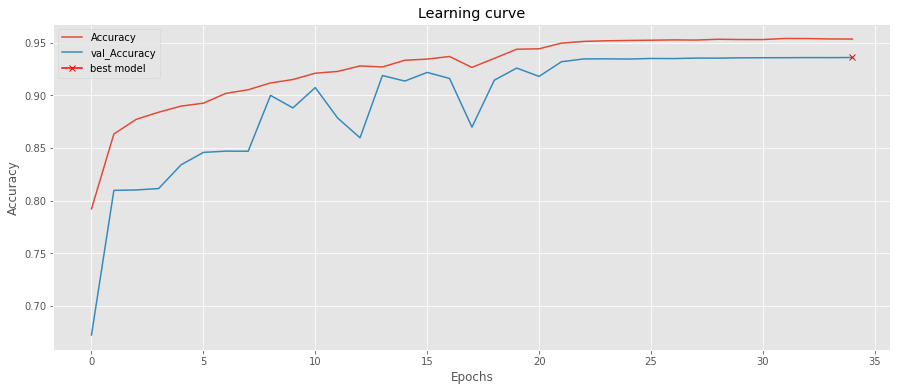

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# **Inference**

In [ ]:
model.load_weights('/content/drive/MyDrive//model-Unet.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 0.1139 - accuracy: 0.9344 - auc: 0.9835 - sensitivity_at_specificity: 0.9917 - specificity_at_sensitivity: 0.9982 - mean_io_u: 0.4225


[0.11389254033565521,
 0.9344472289085388,
 0.9834592342376709,
 0.9917306303977966,
 0.998221755027771,
 0.42253825068473816]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

1/1 [==============================] - 2s 2s/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
from keras.metrics import MeanIoU
num_classes = 2
IOU_keras = MeanIoU(num_classes=num_classes)  
IOU_keras.update_state(y_train,preds_train_t)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.9051532


In [ ]:
!pip install keras_unet_collection
import keras_unet_collection

     |████████████████████████████████| 67 kB 4.5 MB/s 


In [ ]:
from keras_unet_collection import losses

In [ ]:
print('Testing set IoU loss = {}'.format(np.mean(losses.iou_seg(y_train, preds_train_t))))

Testing set IoU loss = 0.11522215604782104


In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellight Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Satellight Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Satelight Image Predicted')
    ax[2].set_axis_off()
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Satellight Mask Image Predicted binary');
    ax[3].set_axis_off()    

# **Predictions on training set**

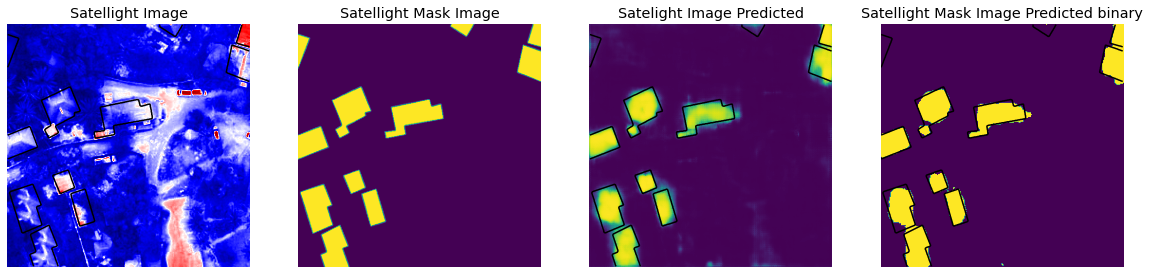

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=3)

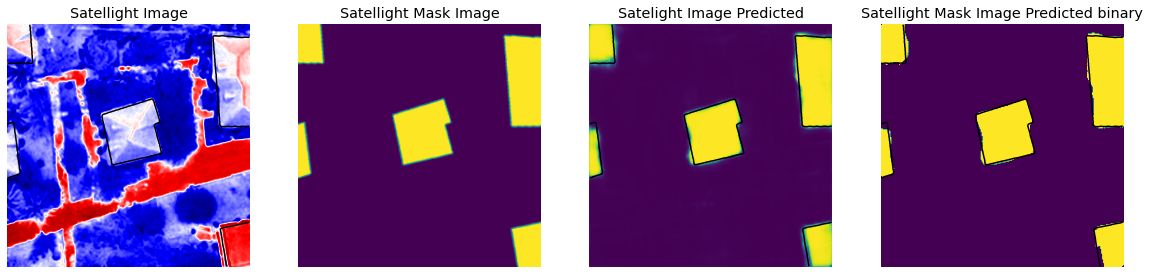

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t, 30)

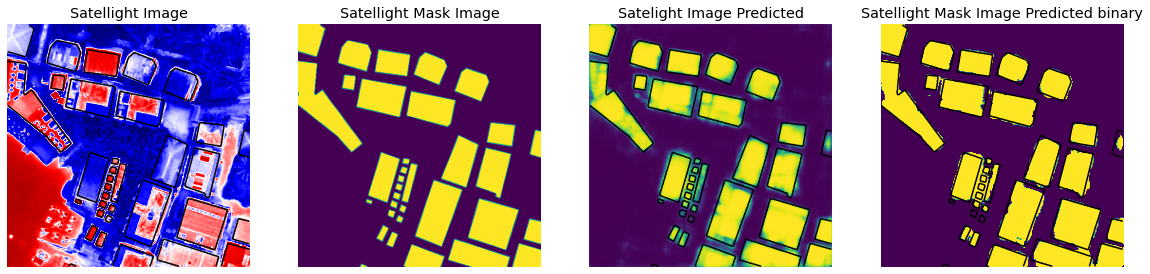

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t, 32)

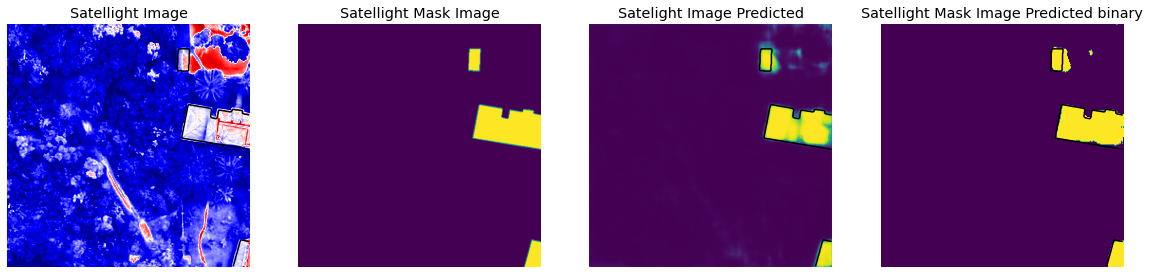

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t,7)

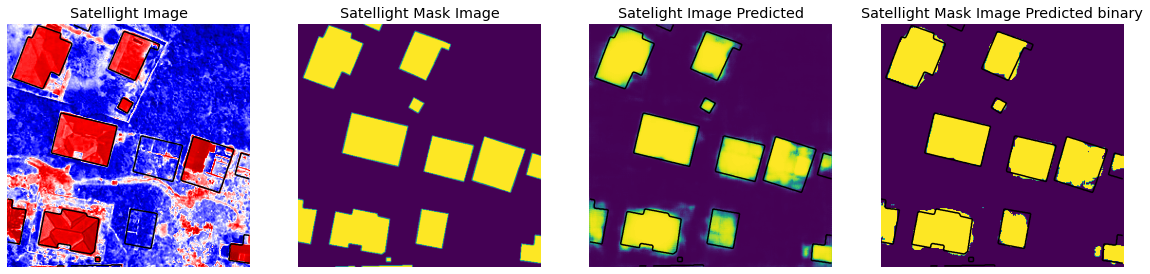

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t, 10)

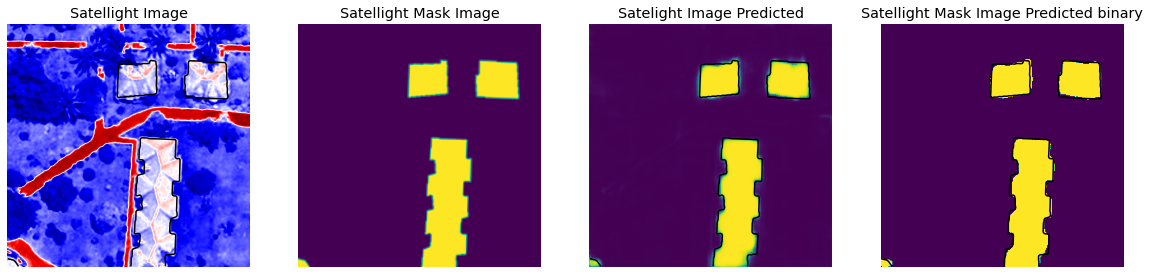

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t, 70)

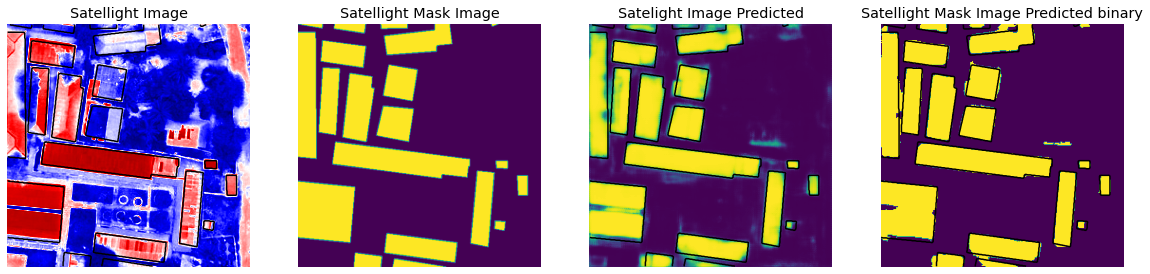

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t,1)

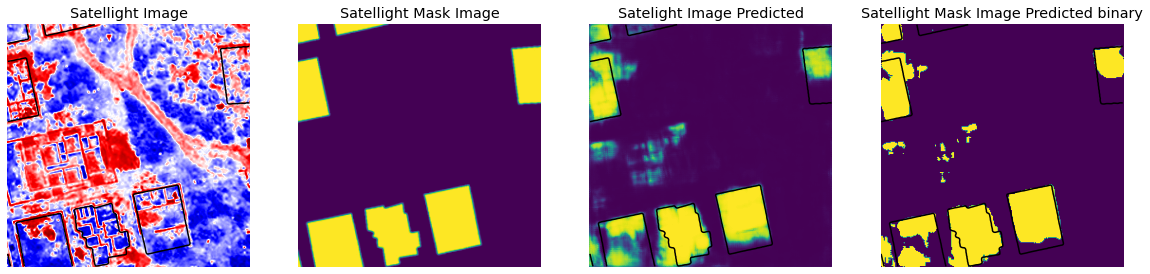

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t,0)

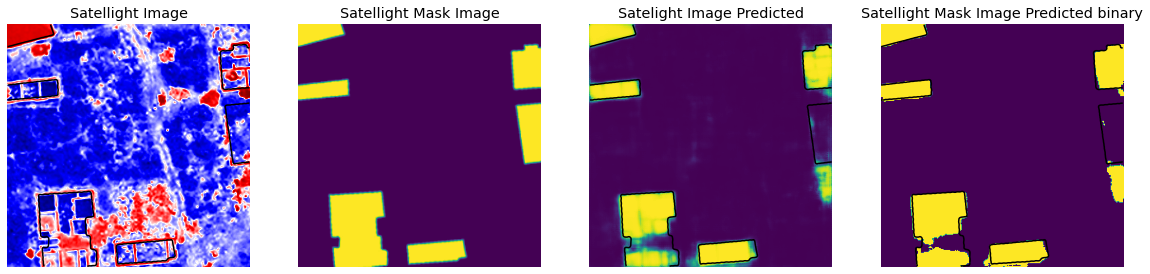

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t,2)

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

IndexError: ignored

In [ ]:
import keras

In [ ]:
!pip install keras_unet_collection

     |████████████████████████████████| 67 kB 3.0 MB/s 


In [ ]:
import numpy as np
from glob import glob
from keras_unet_collection import models, utils

In [ ]:
# file path after data extraction
path_trainval_img = "/content/drive/MyDrive/dataset3/images/256/"
path_trainval_mask = "/content/drive/MyDrive/dataset3/labels/256/"
path_test_img = "/content/drive/MyDrive/dataset3/images/256/"
path_test_mask = "/content/drive/MyDrive/dataset3/labels/256/"

In [ ]:
def split_human_samples(label_filenames, human_id=0, human_rate=1/3):
    '''
    Subsetting samples that contain "person/human" category from the COCO dataset
    ----------
    human_id = 0 : COCO stuffthingmaps label human as int 0
    human_rate = 1/3: at least 33% of the pixels should belong to human.
    ----------
    '''
    thres = int(64*64*human_rate) # pixel number thres after resizing
    L = len(label_filenames)
    flag = [] # return a list of booleans
    for i in range(L):
        sample_ = utils.image_to_array([label_filenames[i]], size=128, channel=1)
        if np.sum(sample_[0, 32:-32, 32:-32, 0]==human_id) > thres:
            flag.append(True)
        else:
            flag.append(False)
        
    return flag

In [ ]:
trainval_input_names = np.array(sorted(glob(path_trainval_img+'*.jpg')))
trainval_label_names = np.array(sorted(glob(path_trainval_mask+'*.png')))
flag_human = split_human_samples(trainval_label_names, human_id=0)
trainval_input_names = trainval_input_names[flag_human]
trainval_label_names = trainval_label_names[flag_human]

In [ ]:
test_input_names = np.array(sorted(glob(path_test_img+'*.jpg')))
test_label_names = np.array(sorted(glob(path_test_mask+'*.png')))
flag_human_test = split_human_samples(test_label_names, human_id=0)
test_input_names = test_input_names[flag_human_test]
test_label_names = test_label_names[flag_human_test]

In [ ]:
L = len(trainval_input_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.9*L); L_valid = L - L_train
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:]

train_input_names = trainval_input_names[ind_train]
train_label_names = trainval_label_names[ind_train]
valid_input_names = trainval_input_names[ind_valid]
valid_label_names = trainval_label_names[ind_valid]

print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, len(test_label_names)))

Training:validation:testing = 90:10:100


In [ ]:
from tensorflow import keras

In [ ]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting human, non-human pixels into two categories.'''
    target_array[target_array>0]=1 # grouping all other non-human categories 
    return keras.utils.to_categorical(target_array, num_classes=1)

In [ ]:
test_input = input_data_process(utils.image_to_array(test_input_names, size=256, channel=3))
test_label = target_data_process(utils.image_to_array(test_label_names, size=256, channel=1))

IndexError: ignored

In [ ]:
y_pred = model.predict([test_input])

In [ ]:
print('Testing set cross-entropy = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_label, y_pred))))

ValueError: ignored